## Classify_df

### Useful links

#### <u>Datasets</u>
Complete dataset: The full dataset of images used can be found [here](https://drive.google.com/drive/folders/1Rz0JrjUCU-4VmDkolbkwUcM8xW1jd9pl?usp=drive_link)

Cropped datasets: The complete dataset has been used by SAM to create segmentations of cells, with some noise, resulting in:
 All these [crops](https://drive.google.com/drive/folders/1Rz0JrjUCU-4VmDkolbkwUcM8xW1jd9pl?usp=drive_link) 
 and all these [csv files](https://frbautneduar-my.sharepoint.com/:u:/g/personal/ntaurozzi_frba_utn_edu_ar/EYKi5F-wXGRNkAqjPSRVhvUByTsnsEB10OrZiJHclkOPWQ?e=tVwmkS) with the information of each crop.

Input/Target dataset: From the complete dataset, some images have been tagged by the biologists an those 58 (for now) can be found [here](https://frbautneduar-my.sharepoint.com/:u:/g/personal/ntaurozzi_frba_utn_edu_ar/EQbvUOwADihJsJLAyVfBdYwBDvHJDMS5GQuyyP_PzUeCLQ?e=z8A7Tn) each image with its corresponding target. The name of the images here are ids given to them by a json file.

#### <u>Auxiliary files</u>
To create the input/target dataset from the complete dataset, this [json](https://drive.google.com/file/d/1ydQ2fIOllwPPU64Kneda4mVidUww1X9T/view?usp=drive_link) was used

#### <u>Models</u>
For making the predictions these [models](https://frbautneduar-my.sharepoint.com/:f:/g/personal/lmareque_frba_utn_edu_ar/EiDo8WYptOpEiyzJHhQIbwoBUAfsoULwRRKEm-fmgzQD-g?e=6TE9yu) will be used

### Code walkthrough

This notebook will process all the images from the input/target dataset. It will use the json file to map the IDs to their original filenames. Then, it will search for all the crops belonging to these images and use all the models to predict whether each crop is noise or a cell. After the prediction, it will store the results in the corresponding CSV file for each image.

The output will be a folder for each model used. Within each folder, a CSV file will be created for each image, containing information about the bounding boxes of each crop and its classification (cell or noise).

### Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import math
import keras
import cv2 as cv
import json
sys.path.insert(0, "../packages/python")

2024-12-27 19:35:15.054702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735338915.165374   32085 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735338915.190526   32085 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 19:35:15.379548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Paths

In [2]:
CSV_PATH = '../output/sam_uploaded_out/'
CROPS_PATH = '../output/cropped_cells_full/'
MODELS_PATH = '../models/'
IMAGES_PATH = '../media/data/input/'
JSON_PATH = '../media/corte-27-02-2024.json'
OUTPUT_PATH = '../output/'

# CSV_PATH = '../untracked/datasets/Abril2023/sam_uploaded_out'
# CROPS_PATH = '../untracked/datasets/Abril2023/cropped_cells'
# MODELS_PATH = '../untracked/test models'
# IMAGES_PATH = '../untracked/datasets/Abril2023/raw_dataset/input'
# JSON_PATH = '../untracked/datasets/Abril2023/corte-28-10-2023.json'

# OUTPUT_PATH = '../untracked/outputs'

### Functions

In [3]:
def predict_cell(model_path, image_path, images_batch):
  """
  Given an image batch it returns the predictions of the batch with the given model.

  Args:
    model_path: path to the keras model to use.
    image_path: path to the folder where the images are.
    images_batch: list of the image names to include in the batch

  Returns:
    A list of predictions.
  """
  images = []
  for image in images_batch:
      img = cv.imread(os.path.join(image_path,image))#, cv.IMREAD_GRAYSCALE)
      img = cv.resize(img, (128, 128))
      img = img / 255.0 
      images.append(img)

  model = keras.models.load_model(model_path)
  batch = np.stack(images)
  prediction = model.predict(batch, verbose=0)

  return prediction #True if prediction >= 0.5 else False


def find_image_name(data, id):
  """
  Given a list of objects it searches the file_name from the id.

  Args:
    data: list of objects to search from.
    id: id of the file name to return.

  Returns:
    The file name of the image id.
  """
  for img in data:
      if img['id'] == id:
          base_name, _ = os.path.splitext(img['file_name'])
          return base_name
        
def get_cells_bbox(data, id):
  """
  Given a list of objects it returns a list of bounding boxes for the given id.

  Args:
    data: list of objects to search from.
    id: id of the objetct to search.

  Returns:
    A list of bounding boxes.
  """
  return [cell['bbox'] for cell in data['annotations'] if cell['image_id'] == id]

def process_images_in_batches(string_list, batch_size=10):
  """
  Processes a list of strings in batches of a specified size.

  Args:
    string_list: The list of strings to process.
    batch_size: The size of each batch.

  Yields:
    A batch of strings.
  """
  for i in range(0, len(string_list), batch_size):
    batch_num = i // batch_size + 1  # Calculate batch number (1-indexed)
    yield batch_num, string_list[i:i + batch_size]

def bb_overlap_percentage(box1, box2):
    
    """
    Calculates the Intersection over Union (IoU) of two bounding boxes using Shapely.

    Args:
        box1: A tuple or list containing (x1, y1, width, height) of the first bounding box.
        box2: A tuple or list containing (x1, y1, width, height) of the second bounding box.

    Returns:
        The IoU value, a float between 0 and 1.
    """

    # Calculate box coordinates
    x1_min, y1_min, width1, height1 = box1
    x1_max = x1_min + width1
    y1_max = y1_min + height1
    x2_min, y2_min, width2, height2 = box2
    x2_max = x2_min + width2
    y2_max = y2_min + height2

    # Create polygons
    poly1 = Polygon([(x1_min, y1_min), (x1_max, y1_min), (x1_max, y1_max), (x1_min, y1_max)])
    poly2 = Polygon([(x2_min, y2_min), (x2_max, y2_min), (x2_max, y2_max), (x2_min, y2_max)])

    # Calculate intersection and union areas
    intersection = poly1.intersection(poly2).area
    union = poly1.union(poly2).area

    # Calculate IoU
    if union == 0:
        return 0.0  # Handle case where boxes don't overlap
    iou = intersection / union

    return iou

def bbox_fully_contained(bbox1, bbox2):
    """
    Checks if bounding box 1 is fully contained within bounding box 2.

    Args:
        bbox1: A tuple (x1, y1, width1, height1) representing the first bounding box.
        bbox2: A tuple (x2, y2, width2, height2) representing the second bounding box.

    Returns:
        True if bbox1 is fully contained within bbox2, False otherwise.
    """

    # Calculate coordinates of bounding boxes
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    bbox1_coords = [(x1, y1), (x1 + w1, y1), (x1 + w1, y1 + h1), (x1, y1 + h1)]
    bbox2_coords = [(x2, y2), (x2 + w2, y2), (x2 + w2, y2 + h2), (x2, y2 + h2)]

    # Create Shapely polygons
    poly1 = Polygon(bbox1_coords)
    poly2 = Polygon(bbox2_coords)

    # Check if bbox1 is fully contained within bbox2
    return poly1.within(poly2)

def bbox_intercept(bbox, bbox_list, threshold=0):
  for idx, bbox_target in enumerate(bbox_list):
    if threshold > 0:
      iou = bb_overlap_percentage(bbox, bbox_target)
      if iou >= threshold:
        return True, idx
      
    else:
      contained = bbox_fully_contained(bbox, bbox_target)
      if contained:
        return True, idx
  
  return False, -1

### Lists of elements to use

In [4]:
csvs = sorted(os.listdir(CSV_PATH)) #Paths to the csv of SAM detections of each image
crops = sorted(os.listdir(CROPS_PATH)) #Paths to the crops made from SAM detection of the full_images
models = sorted(os.listdir(MODELS_PATH)) #Models to use in the prediction
og_images = sorted(os.listdir(IMAGES_PATH)) #full_images from where the crops are made
with open(JSON_PATH, 'r') as f: #json with the information of the filename of the images
    data = json.load(f)

### Model prediction

In [ ]:
for model_idx, model in enumerate(models):

    base_model, ext = os.path.splitext(model)
    if '.keras' != ext:
        continue

    output = os.path.join(OUTPUT_PATH, "evaluated", base_model)
    
    if not os.path.exists(output): #Create dirs for each model used
        os.makedirs(output)

    for og_image_idx, og_image in enumerate(og_images):
        img_name, _ = os.path.splitext(og_image)
        real_name = find_image_name(data['images'], int(img_name)) #Find the real image name from where the crops where made
        bboxes_coco =  get_cells_bbox(data, int(img_name)) #Get all bboxes_coco from the tagged images

        images = sorted([crop for crop in crops if crop.startswith(real_name)]) #Get all the crops from that image
        df = pd.read_csv(os.path.join(CSV_PATH, f"{real_name}.csv")) #Read the csv of that image
        bboxes_sam = [tuple(map(int, row)) for row in df[['x', 'y', 'w', 'h']].values] 
        df = df.rename(columns={'cell_id': 'cell_id_sam'})

        batch_size=30
        for idx, batch in process_images_in_batches(images, batch_size=batch_size): #Read the images in batch_size batches
            print(f"Model: {model} ({model_idx+1}/{len(models)}) - Image: {og_image} ({og_image_idx+1}/{len(og_images)}) - Batch {idx}/{math.ceil(len(images)/batch_size)}", end='\r')

            batch_prediction = predict_cell(model_path=os.path.join(MODELS_PATH, model), image_path=CROPS_PATH, images_batch=batch)
            is_cell = [True if sublist[0] >= 0.5 else False for sublist in batch_prediction]

            # For each image in the batch store the prediction in the csv toghether with the cell_id of the coco tags
            for idx, i in enumerate(batch):
                crop_name, _ = os.path.splitext(i)
                cell_id = crop_name.split('_')[2]

                mask = (df['cell_id_sam'] == int(cell_id)) & (df['image'] == real_name)
                filtered_df = df[mask]

                df.loc[mask, 'is_cell_sam'] = is_cell[idx]
                df.loc[mask, 'image'] = img_name 
                x, y, w, h = filtered_df[['x', 'y', 'w', 'h']].values[0]
                intercept, cell_id_coco = bbox_intercept((x,y,w,h), bboxes_coco)
                df.loc[mask, 'cell_id_coco'] = int(cell_id_coco)
                df.loc[mask, 'is_cell_ground_truth'] = intercept

        #For each cell in coco i check if it was not detected by sam
        for idx, bbox_coco in enumerate(bboxes_coco):
            intercept, _ = bbox_intercept(bbox_coco, bboxes_sam)
            if not intercept:
                new_row = {'area': 0,'x':bbox_coco[0] ,'y':bbox_coco[1],'w':bbox_coco[2],'h':bbox_coco[3],
                            'bbox_area':bbox_coco[2]*bbox_coco[3],'image':img_name,'cell_id_sam':-1,
                            'is_cell_sam':False,'cell_id_coco':idx,'is_cell_ground_truth':True}
                df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            
        # Configure the dataframe to store it
        df['cell_id_coco'] = df['cell_id_coco'].astype(int)
        df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)
        df.to_csv(os.path.join(output, f"{img_name}.csv"))


#### Functions testing

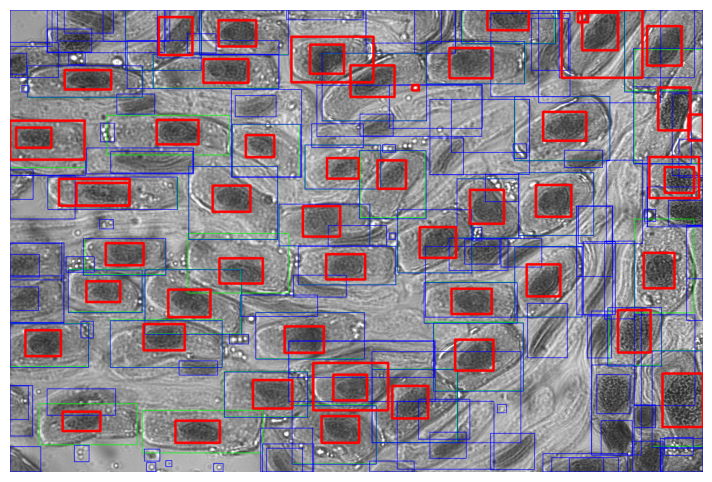

In [ ]:
img_num = 331
df = pd.read_csv(f"{'../output/evaluated/DenseNet121/' + str(img_num)}.csv")
bboxes_og =  get_cells_bbox(data, img_num)
bboxes_sam = [tuple(map(int, row)) for row in df[['x', 'y', 'w', 'h']].values] 
img = cv.imread(f'{IMAGES_PATH + str(img_num)}.png')

for bbox in bboxes_og:
    x, y, w, h = bbox
    x1, y1 = int(x), int(y)
    x2, y2 = int(x + w), int(y + h)
    cv.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

for bbox in bboxes_sam:
    x, y, w, h = bbox
    x1, y1 = int(x), int(y)
    x2, y2 = int(x + w), int(y + h)
    cv.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

for bbox_sam in bboxes_sam:
    for bbox_og in bboxes_og:
        # if bb_overlap_percentage(bbox_sam, bbox_og) >= 0.2:
        if bbox_fully_contained(bbox_sam, bbox_og):
        # if bbox_fully_contained(bbox_sam, bbox_og) or bb_overlap_percentage(bbox_sam, bbox_og) >= 0.8:
            x, y, w, h = bbox_sam
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
            cv.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 10)

plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

# Results

In [14]:
for model_idx, model in enumerate(models):
    output = os.path.join(OUTPUT_PATH, "evaluated", base_model)
    if not os.path.exists(output):
        continue
    for og_image_idx, og_image in enumerate(og_images):
        df = pd.read_csv(os.path.join(output, f"{img_name}.csv"))
        asdasd 

NameError: name 'asdasd' is not defined

In [15]:
df

,Unnamed: 0.1,Unnamed: 0,area,x,y,w,h,bbox_area,image,cell_id,is_cell
0,0,0,37780,80,1819,202,228,46056,392,0,True
1,1,1,23444,1542,1927,250,120,30000,392,1,False
2,2,2,57410,1238,1032,266,289,76874,392,2,False
3,3,3,50979,1020,1089,213,295,62835,392,3,True
4,4,4,26447,928,809,182,184,33488,392,4,False
...,...,...,...,...,...,...,...,...,...,...,...
196,196,196,29443,2670,155,267,151,40317,392,196,False
197,197,197,883,905,848,34,31,1054,392,197,False
198,198,198,14629,387,1578,142,174,24708,392,198,False
199,199,199,4920,432,1837,115,73,8395,392,199,False
